<img src="../images/churn_icon.png" width="400"/>

# Main models

Modelos utilizando todo el data.

- [Seguir a partir del checkpoint](#item1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import datetime as dt
from tools import dataoveriew, plot_roc_curve, plot_confusion_matrix
from datetime import datetime
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pickle

# Using Activo and Baja for 0 and 1    
class_names = ['Activo','Baja']

pd.options.display.max_columns = None

%matplotlib inline

In [2]:
data = pd.read_excel('../data/portfolio.xlsx')

data['Cliente'] = data['Cliente'].astype('str')
data['Quejas'] = data['Quejas'].replace(np.nan, 0).astype('int')
data['Incidencias'] = data['Incidencias'].replace(np.nan, 0).astype('int')
data['Status'] = data['Status'].astype('str').str.strip()
data['Status'] = data['Status'].replace({'ACTIVO': 0, 'BAJA': 1}).astype(int)

data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias
0,2015-01-02,1,Normal,V1,Granada,HOMBRE,ES - ESPAÑOLA,1959-09-02,2 - PROPIEDAD HIPOTECADA,03 FUNCIONARIO,2 - CASADO,2000,13,2019-06-30,1,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,0,0
1,2015-01-02,2,Normal,V1,Barcelona,MUJER,ES - ESPAÑOLA,1971-04-15,4 - FAMILIARES/PADRES,06 PARADO,4 - SEPARADO/DIVORCIADO,600,12,2015-01-05,0,Apartamento,Financiado,Entre 000-050,49+(36*10),49,409,10,12,16
2,2015-01-02,3,Normal,V1,Madrid Noroeste,HOMBRE,ES - ESPAÑOLA,1968-02-10,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,4 - SEPARADO/DIVORCIADO,2500,14,2015-01-05,0,Apartamento,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0
3,2015-01-02,4,Normal,V1,Sevilla,MUJER,ES - ESPAÑOLA,1968-12-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1800,12,2015-01-13,0,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,2,0
4,2015-01-02,5,Normal,V1,Barcelona,HOMBRE,ES - ESPAÑOLA,1977-02-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1500,12,2015-01-07,0,Tienda,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0


In [3]:
data.shape

(548136, 24)

## Feature engineering

- Edad en Años
- Rango de Income Amount
- Días Activo escalado
- Escalado de 'Quejas' y 'MT

Rangos de Edad:

In [4]:
data.columns

Index(['Start Date', 'Cliente', 'Client Type', 'Modelo', 'Provincia', 'Gender',
       'Nationality', 'Born Date', 'Housing Type', 'Labor Situation',
       'Marital Status', 'Income Amount', 'Number Pay', 'Status Date',
       'Status', 'Property Type', 'Financiado', 'Rango Precio',
       'Resumen Precio', 'Precio Contado', 'Precio Total',
       'Precio Mensualidad', 'Quejas', 'Incidencias'],
      dtype='object')

In [5]:
data['Born Date'].isnull().sum()

2039

In [6]:
data['Born Date'] = data['Born Date'].replace(np.nan, datetime(1970, 1, 1))

data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias
0,2015-01-02,1,Normal,V1,Granada,HOMBRE,ES - ESPAÑOLA,1959-09-02,2 - PROPIEDAD HIPOTECADA,03 FUNCIONARIO,2 - CASADO,2000,13,2019-06-30,1,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,0,0
1,2015-01-02,2,Normal,V1,Barcelona,MUJER,ES - ESPAÑOLA,1971-04-15,4 - FAMILIARES/PADRES,06 PARADO,4 - SEPARADO/DIVORCIADO,600,12,2015-01-05,0,Apartamento,Financiado,Entre 000-050,49+(36*10),49,409,10,12,16
2,2015-01-02,3,Normal,V1,Madrid Noroeste,HOMBRE,ES - ESPAÑOLA,1968-02-10,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,4 - SEPARADO/DIVORCIADO,2500,14,2015-01-05,0,Apartamento,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0
3,2015-01-02,4,Normal,V1,Sevilla,MUJER,ES - ESPAÑOLA,1968-12-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1800,12,2015-01-13,0,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,2,0
4,2015-01-02,5,Normal,V1,Barcelona,HOMBRE,ES - ESPAÑOLA,1977-02-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1500,12,2015-01-07,0,Tienda,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0


In [7]:
data['Born Date'].isnull().sum()

0

In [10]:
# Edad actual si ACTIVO y edad cuando se dio de baja si BAJA

data['Edad'] = 0
fecha = datetime(2021, 1, 19)

for i in range(len(data['Born Date'])):
    if data.loc[i, 'Status'] == 0:
        data.loc[i,'Edad'] = ((fecha - data.loc[i,'Born Date']).days)/365
    else:
        data.loc[i,'Edad'] = ((data.loc[i,'Status Date'] - data.loc[i,'Born Date']).days)/365
                        
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad
0,2015-01-02,1,Normal,V1,Granada,HOMBRE,ES - ESPAÑOLA,1959-09-02,2 - PROPIEDAD HIPOTECADA,03 FUNCIONARIO,2 - CASADO,2000,13,2019-06-30,1,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,0,0,59.865753
1,2015-01-02,2,Normal,V1,Barcelona,MUJER,ES - ESPAÑOLA,1971-04-15,4 - FAMILIARES/PADRES,06 PARADO,4 - SEPARADO/DIVORCIADO,600,12,2015-01-05,0,Apartamento,Financiado,Entre 000-050,49+(36*10),49,409,10,12,16,49.800000
2,2015-01-02,3,Normal,V1,Madrid Noroeste,HOMBRE,ES - ESPAÑOLA,1968-02-10,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,4 - SEPARADO/DIVORCIADO,2500,14,2015-01-05,0,Apartamento,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0,52.978082
3,2015-01-02,4,Normal,V1,Sevilla,MUJER,ES - ESPAÑOLA,1968-12-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1800,12,2015-01-13,0,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,2,0,52.112329
4,2015-01-02,5,Normal,V1,Barcelona,HOMBRE,ES - ESPAÑOLA,1977-02-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1500,12,2015-01-07,0,Tienda,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0,43.936986


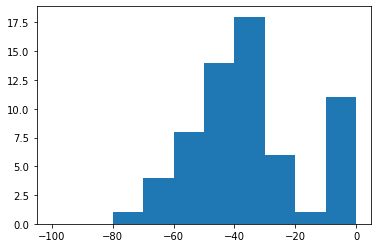

In [11]:
plt.hist(data['Edad'], range = (-100,0));

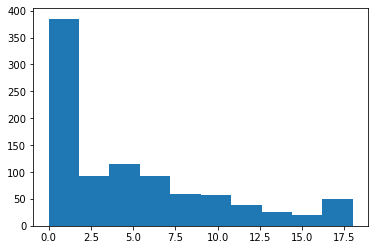

In [12]:
plt.hist(data['Edad'], range = (0,18));

In [13]:
data['Edad'].mean()

52.69764619459684

In [14]:
for i in range(len(data['Edad'])):
    if data.loc[i, 'Edad'] < 18:
        data.loc[i, 'Edad'] = data['Edad'].mean()
    else:
        continue

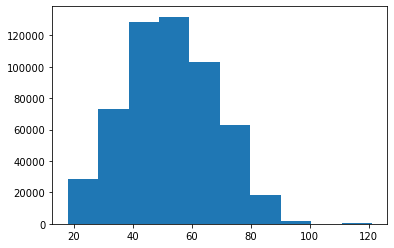

In [15]:
plt.hist(data['Edad']);

In [16]:
# Mapping Edad 
data.loc[data['Edad'] <= 30, 'Rango_Edad'] = "18-30"
data.loc[(data['Edad'] > 30) & (data['Edad'] <= 40), 'Rango_Edad'] = "30-40"
data.loc[(data['Edad'] > 40) & (data['Edad'] <= 50), 'Rango_Edad'] = "40-50"
data.loc[(data['Edad'] > 50) & (data['Edad'] <= 60), 'Rango_Edad'] = "50-60"
data.loc[(data['Edad'] > 60) & (data['Edad'] <= 70), 'Rango_Edad'] = "60-70"
data.loc[(data['Edad'] > 70) & (data['Edad'] <= 80), 'Rango_Edad'] = "70-80"
data.loc[data['Edad'] > 80, 'Rango_Edad'] = "+80"
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad,Rango_Edad
0,2015-01-02,1,Normal,V1,Granada,HOMBRE,ES - ESPAÑOLA,1959-09-02,2 - PROPIEDAD HIPOTECADA,03 FUNCIONARIO,2 - CASADO,2000,13,2019-06-30,1,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,0,0,59.865753,50-60
1,2015-01-02,2,Normal,V1,Barcelona,MUJER,ES - ESPAÑOLA,1971-04-15,4 - FAMILIARES/PADRES,06 PARADO,4 - SEPARADO/DIVORCIADO,600,12,2015-01-05,0,Apartamento,Financiado,Entre 000-050,49+(36*10),49,409,10,12,16,49.800000,40-50
2,2015-01-02,3,Normal,V1,Madrid Noroeste,HOMBRE,ES - ESPAÑOLA,1968-02-10,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,4 - SEPARADO/DIVORCIADO,2500,14,2015-01-05,0,Apartamento,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0,52.978082,50-60
3,2015-01-02,4,Normal,V1,Sevilla,MUJER,ES - ESPAÑOLA,1968-12-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1800,12,2015-01-13,0,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,2,0,52.112329,50-60
4,2015-01-02,5,Normal,V1,Barcelona,HOMBRE,ES - ESPAÑOLA,1977-02-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1500,12,2015-01-07,0,Tienda,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0,43.936986,40-50


In [17]:
tab1 = pd.crosstab(data["Rango_Edad"], data["Status"], margins = True)
tab2 = pd.crosstab(data["Rango_Edad"], data["Status"], margins = True, normalize = 'index')
pd.concat([tab1, tab2], axis = 1)

Status,0,1,All,0,1
Rango_Edad,,,,,
+80,17249,2780,20029,0.861201,0.138799
18-30,22087,14148,36235,0.609549,0.390451
30-40,49962,29462,79424,0.629054,0.370946
40-50,93103,34640,127743,0.728831,0.271169
50-60,101045,25303,126348,0.799736,0.200264
60-70,83909,14657,98566,0.851298,0.148702
70-80,52518,7273,59791,0.878360,0.121640
All,419873,128263,548136,0.766002,0.233998


Rangos de Income Amount:

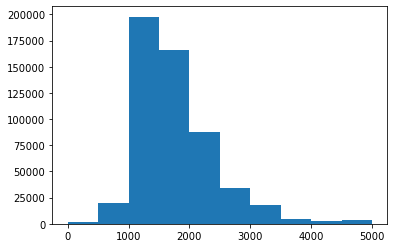

In [18]:
plt.hist(data['Income Amount'], range=(0, 5000));

In [19]:
# Mapping Income Amount
data.loc[data['Income Amount'] <= 1000, 'Income'] = "0-1000"
data.loc[(data['Income Amount'] > 1000) & (data['Income Amount'] <= 1500), 'Income'] = "1000-1500"
data.loc[(data['Income Amount'] > 1500) & (data['Income Amount'] <= 2000), 'Income'] = "1500-2000"
data.loc[(data['Income Amount'] > 2000) & (data['Income Amount'] <= 3000), 'Income'] = "2000-3000"
data.loc[data['Income Amount'] > 3000, 'Income'] = "+3000"
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad,Rango_Edad,Income
0,2015-01-02,1,Normal,V1,Granada,HOMBRE,ES - ESPAÑOLA,1959-09-02,2 - PROPIEDAD HIPOTECADA,03 FUNCIONARIO,2 - CASADO,2000,13,2019-06-30,1,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,0,0,59.865753,50-60,1500-2000
1,2015-01-02,2,Normal,V1,Barcelona,MUJER,ES - ESPAÑOLA,1971-04-15,4 - FAMILIARES/PADRES,06 PARADO,4 - SEPARADO/DIVORCIADO,600,12,2015-01-05,0,Apartamento,Financiado,Entre 000-050,49+(36*10),49,409,10,12,16,49.800000,40-50,0-1000
2,2015-01-02,3,Normal,V1,Madrid Noroeste,HOMBRE,ES - ESPAÑOLA,1968-02-10,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,4 - SEPARADO/DIVORCIADO,2500,14,2015-01-05,0,Apartamento,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0,52.978082,50-60,2000-3000
3,2015-01-02,4,Normal,V1,Sevilla,MUJER,ES - ESPAÑOLA,1968-12-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1800,12,2015-01-13,0,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,2,0,52.112329,50-60,1500-2000
4,2015-01-02,5,Normal,V1,Barcelona,HOMBRE,ES - ESPAÑOLA,1977-02-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1500,12,2015-01-07,0,Tienda,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0,43.936986,40-50,1000-1500


In [20]:
tab1 = pd.crosstab(data["Income"], data["Status"], margins = True)
tab2 = pd.crosstab(data["Income"], data["Status"], margins = True, normalize = 'index')
pd.concat([tab1, tab2], axis = 1)

Status,0,1,All,0,1
Income,,,,,
+3000,19591,5008,24599,0.796414,0.203586
0-1000,57599,22344,79943,0.720501,0.279499
1000-1500,192982,60784,253766,0.760472,0.239528
1500-2000,101030,28232,129262,0.781591,0.218409
2000-3000,48671,11895,60566,0.803603,0.196397
All,419873,128263,548136,0.766002,0.233998


Días Activo:

In [21]:
# Días hasta el 19/01/2021 si ACTIVO y hasta cuando se dio de baja si BAJA

data['Dias_Activo'] = 0
fecha = datetime(2021, 1, 19)

for i in range(len(data['Start Date'])):
    if data.loc[i, 'Status'] == 0:
        data.loc[i,'Dias_Activo'] = (fecha - data.loc[i,'Start Date']).days
    else:
        data.loc[i,'Dias_Activo'] = (data.loc[i,'Status Date'] - data.loc[i,'Start Date']).days
                        
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad,Rango_Edad,Income,Dias_Activo
0,2015-01-02,1,Normal,V1,Granada,HOMBRE,ES - ESPAÑOLA,1959-09-02,2 - PROPIEDAD HIPOTECADA,03 FUNCIONARIO,2 - CASADO,2000,13,2019-06-30,1,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,0,0,59.865753,50-60,1500-2000,1640
1,2015-01-02,2,Normal,V1,Barcelona,MUJER,ES - ESPAÑOLA,1971-04-15,4 - FAMILIARES/PADRES,06 PARADO,4 - SEPARADO/DIVORCIADO,600,12,2015-01-05,0,Apartamento,Financiado,Entre 000-050,49+(36*10),49,409,10,12,16,49.800000,40-50,0-1000,2209
2,2015-01-02,3,Normal,V1,Madrid Noroeste,HOMBRE,ES - ESPAÑOLA,1968-02-10,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,4 - SEPARADO/DIVORCIADO,2500,14,2015-01-05,0,Apartamento,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0,52.978082,50-60,2000-3000,2209
3,2015-01-02,4,Normal,V1,Sevilla,MUJER,ES - ESPAÑOLA,1968-12-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1800,12,2015-01-13,0,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,2,0,52.112329,50-60,1500-2000,2209
4,2015-01-02,5,Normal,V1,Barcelona,HOMBRE,ES - ESPAÑOLA,1977-02-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1500,12,2015-01-07,0,Tienda,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0,43.936986,40-50,1000-1500,2209


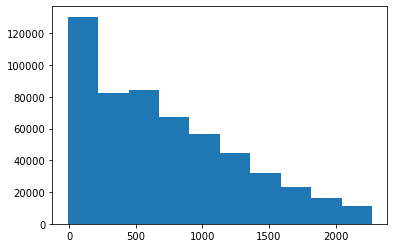

In [22]:
plt.hist(data['Dias_Activo']);

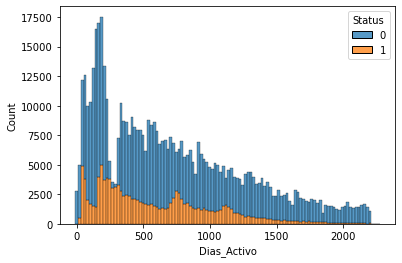

In [23]:
sns.histplot(data = data, x = 'Dias_Activo', hue = 'Status', multiple = 'stack')

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data['Dias_Activo_sca'] = scaler.fit_transform(data['Dias_Activo'].values.reshape(-1, 1))

data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad,Rango_Edad,Income,Dias_Activo,Dias_Activo_sca
0,2015-01-02,1,Normal,V1,Granada,HOMBRE,ES - ESPAÑOLA,1959-09-02,2 - PROPIEDAD HIPOTECADA,03 FUNCIONARIO,2 - CASADO,2000,13,2019-06-30,1,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,0,0,59.865753,50-60,1500-2000,1640,0.722976
1,2015-01-02,2,Normal,V1,Barcelona,MUJER,ES - ESPAÑOLA,1971-04-15,4 - FAMILIARES/PADRES,06 PARADO,4 - SEPARADO/DIVORCIADO,600,12,2015-01-05,0,Apartamento,Financiado,Entre 000-050,49+(36*10),49,409,10,12,16,49.800000,40-50,0-1000,2209,0.971991
2,2015-01-02,3,Normal,V1,Madrid Noroeste,HOMBRE,ES - ESPAÑOLA,1968-02-10,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,4 - SEPARADO/DIVORCIADO,2500,14,2015-01-05,0,Apartamento,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0,52.978082,50-60,2000-3000,2209,0.971991
3,2015-01-02,4,Normal,V1,Sevilla,MUJER,ES - ESPAÑOLA,1968-12-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1800,12,2015-01-13,0,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,2,0,52.112329,50-60,1500-2000,2209,0.971991
4,2015-01-02,5,Normal,V1,Barcelona,HOMBRE,ES - ESPAÑOLA,1977-02-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1500,12,2015-01-07,0,Tienda,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0,43.936986,40-50,1000-1500,2209,0.971991


In [25]:
filename = '../pkl/dias_activo_sca.pkl'
dias_activo_sca = scaler.fit(data['Dias_Activo'].values.reshape(-1, 1))

pickle.dump(dias_activo_sca, open(filename,'wb'))

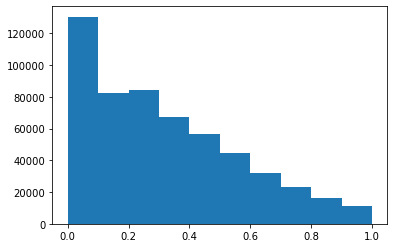

In [26]:
plt.hist(data['Dias_Activo_sca']);

Escalado de Quejas y Missing Test (MT):

In [27]:
scaler = MinMaxScaler()
data['Quejas_sca'] = scaler.fit_transform(data['Quejas'].values.reshape(-1, 1))
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad,Rango_Edad,Income,Dias_Activo,Dias_Activo_sca,Quejas_sca
0,2015-01-02,1,Normal,V1,Granada,HOMBRE,ES - ESPAÑOLA,1959-09-02,2 - PROPIEDAD HIPOTECADA,03 FUNCIONARIO,2 - CASADO,2000,13,2019-06-30,1,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,0,0,59.865753,50-60,1500-2000,1640,0.722976,0.000000
1,2015-01-02,2,Normal,V1,Barcelona,MUJER,ES - ESPAÑOLA,1971-04-15,4 - FAMILIARES/PADRES,06 PARADO,4 - SEPARADO/DIVORCIADO,600,12,2015-01-05,0,Apartamento,Financiado,Entre 000-050,49+(36*10),49,409,10,12,16,49.800000,40-50,0-1000,2209,0.971991,0.260870
2,2015-01-02,3,Normal,V1,Madrid Noroeste,HOMBRE,ES - ESPAÑOLA,1968-02-10,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,4 - SEPARADO/DIVORCIADO,2500,14,2015-01-05,0,Apartamento,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0,52.978082,50-60,2000-3000,2209,0.971991,0.000000
3,2015-01-02,4,Normal,V1,Sevilla,MUJER,ES - ESPAÑOLA,1968-12-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1800,12,2015-01-13,0,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,2,0,52.112329,50-60,1500-2000,2209,0.971991,0.043478
4,2015-01-02,5,Normal,V1,Barcelona,HOMBRE,ES - ESPAÑOLA,1977-02-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1500,12,2015-01-07,0,Tienda,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0,43.936986,40-50,1000-1500,2209,0.971991,0.000000


In [28]:
filename = '../pkl/quejas_sca.pkl'
quejas_sca = scaler.fit(data['Quejas'].values.reshape(-1, 1))

pickle.dump(quejas_sca, open(filename,'wb'))

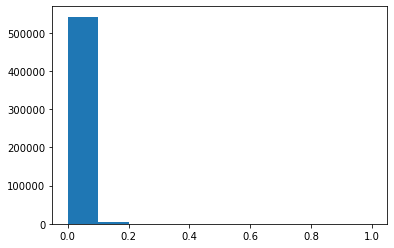

In [29]:
plt.hist(data['Quejas_sca']);

In [30]:
scaler = MinMaxScaler()
data['Incidencias_sca'] = scaler.fit_transform(data['Incidencias'].values.reshape(-1, 1))
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad,Rango_Edad,Income,Dias_Activo,Dias_Activo_sca,Quejas_sca,Incidencias_sca
0,2015-01-02,1,Normal,V1,Granada,HOMBRE,ES - ESPAÑOLA,1959-09-02,2 - PROPIEDAD HIPOTECADA,03 FUNCIONARIO,2 - CASADO,2000,13,2019-06-30,1,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,0,0,59.865753,50-60,1500-2000,1640,0.722976,0.000000,0.000000
1,2015-01-02,2,Normal,V1,Barcelona,MUJER,ES - ESPAÑOLA,1971-04-15,4 - FAMILIARES/PADRES,06 PARADO,4 - SEPARADO/DIVORCIADO,600,12,2015-01-05,0,Apartamento,Financiado,Entre 000-050,49+(36*10),49,409,10,12,16,49.800000,40-50,0-1000,2209,0.971991,0.260870,0.058182
2,2015-01-02,3,Normal,V1,Madrid Noroeste,HOMBRE,ES - ESPAÑOLA,1968-02-10,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,4 - SEPARADO/DIVORCIADO,2500,14,2015-01-05,0,Apartamento,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0,52.978082,50-60,2000-3000,2209,0.971991,0.000000,0.000000
3,2015-01-02,4,Normal,V1,Sevilla,MUJER,ES - ESPAÑOLA,1968-12-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1800,12,2015-01-13,0,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,2,0,52.112329,50-60,1500-2000,2209,0.971991,0.043478,0.000000
4,2015-01-02,5,Normal,V1,Barcelona,HOMBRE,ES - ESPAÑOLA,1977-02-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1500,12,2015-01-07,0,Tienda,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0,43.936986,40-50,1000-1500,2209,0.971991,0.000000,0.000000


In [31]:
filename = '../pkl/incidencias_sca.pkl'
mt_sca = scaler.fit(data['Incidencias'].values.reshape(-1, 1))

pickle.dump(mt_sca, open(filename,'wb'))

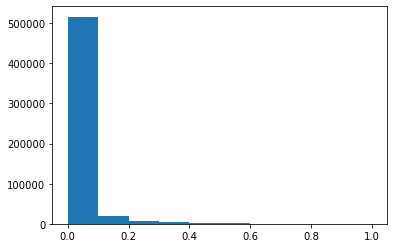

In [32]:
plt.hist(data['Incidencias_sca']);

#### Checkpoint `.pkl`

Creación del checkpoint:

In [33]:
filename = '../pkl/data.pkl'

pickle.dump(data, open(filename,'wb'))

<a name="item1"></a>
Carga del checkpoint:

In [2]:
filename = '../pkl/data.pkl'
data = pickle.load(open(filename, 'rb'))
data.head()

,Start Date,Cliente,Client Type,Modelo,Provincia,Gender,Nationality,Born Date,Housing Type,Labor Situation,Marital Status,Income Amount,Number Pay,Status Date,Status,Property Type,Financiado,Rango Precio,Resumen Precio,Precio Contado,Precio Total,Precio Mensualidad,Quejas,Incidencias,Edad,Rango_Edad,Income,Dias_Activo,Dias_Activo_sca,Quejas_sca,Incidencias_sca
0,2015-01-02,1,Normal,V1,Granada,HOMBRE,ES - ESPAÑOLA,1959-09-02,2 - PROPIEDAD HIPOTECADA,03 FUNCIONARIO,2 - CASADO,2000,13,2019-06-30,1,"Chalet, villa",Financiado,A 0,0+(36*10),0,360,10,0,0,59.865753,50-60,1500-2000,1640,0.722976,0.000000,0.000000
1,2015-01-02,2,Normal,V1,Barcelona,MUJER,ES - ESPAÑOLA,1971-04-15,4 - FAMILIARES/PADRES,06 PARADO,4 - SEPARADO/DIVORCIADO,600,12,2015-01-05,0,Apartamento,Financiado,Entre 000-050,49+(36*10),49,409,10,12,16,49.800000,40-50,0-1000,2209,0.971991,0.260870,0.058182
2,2015-01-02,3,Normal,V1,Madrid Noroeste,HOMBRE,ES - ESPAÑOLA,1968-02-10,1 - PROPIEDAD SIN HIPOTECA,01 ASALARIADO FIJO,4 - SEPARADO/DIVORCIADO,2500,14,2015-01-05,0,Apartamento,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0,52.978082,50-60,2000-3000,2209,0.971991,0.000000,0.000000
3,2015-01-02,4,Normal,V1,Sevilla,MUJER,ES - ESPAÑOLA,1968-12-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1800,12,2015-01-13,0,"Chalet, villa",Financiado,Entre 000-050,49+(36*10),49,409,10,2,0,52.112329,50-60,1500-2000,2209,0.971991,0.043478,0.000000
4,2015-01-02,5,Normal,V1,Barcelona,HOMBRE,ES - ESPAÑOLA,1977-02-22,2 - PROPIEDAD HIPOTECADA,04 AUTONOMO,2 - CASADO,1500,12,2015-01-07,0,Tienda,Financiado,Entre 050-100,99+(36*10),99,459,10,0,0,43.936986,40-50,1000-1500,2209,0.971991,0.000000,0.000000


## Enconding con ``target encoding``

In [3]:
data.columns

Index(['Start Date', 'Cliente', 'Client Type', 'Modelo', 'Provincia', 'Gender',
       'Nationality', 'Born Date', 'Housing Type', 'Labor Situation',
       'Marital Status', 'Income Amount', 'Number Pay', 'Status Date',
       'Status', 'Property Type', 'Financiado', 'Rango Precio',
       'Resumen Precio', 'Precio Contado', 'Precio Total',
       'Precio Mensualidad', 'Quejas', 'Incidencias', 'Edad', 'Rango_Edad',
       'Income', 'Dias_Activo', 'Dias_Activo_sca', 'Quejas_sca',
       'Incidencias_sca'],
      dtype='object')

In [4]:
data_filtered = data[['Gender', 'Housing Type', 'Property Type', 'Labor Situation', 'Marital Status',
                      'Provincia', 'Nationality', 'Rango_Edad', 'Income', 'Rango Precio', 'Number Pay', 'Dias_Activo_sca',
                      'Quejas_sca', 'Incidencias_sca', 'Status']]
data_filtered.columns

Index(['Gender', 'Housing Type', 'Property Type', 'Labor Situation',
       'Marital Status', 'Provincia', 'Nationality', 'Rango_Edad', 'Income',
       'Rango Precio', 'Number Pay', 'Dias_Activo_sca', 'Quejas_sca',
       'Incidencias_sca', 'Status'],
      dtype='object')

In [5]:
X = data_filtered.drop(['Status'],axis=1)
y = data_filtered['Status']

In [6]:
from sklearn.model_selection import train_test_split
X_train_prev, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [7]:
features_TE = ['Gender', 'Housing Type', 'Property Type', 'Labor Situation', 'Marital Status',
                      'Provincia', 'Nationality', 'Rango_Edad', 'Income', 'Rango Precio', 'Number Pay']

In [8]:
from category_encoders import TargetEncoder

TE_encoder = TargetEncoder(cols=features_TE)

In [9]:
X_train_prev.head()

,Gender,Housing Type,Property Type,Labor Situation,Marital Status,Provincia,Nationality,Rango_Edad,Income,Rango Precio,Number Pay,Dias_Activo_sca,Quejas_sca,Incidencias_sca
161310,HOMBRE,1 - PROPIEDAD SIN HIPOTECA,Apartamento,01 ASALARIADO FIJO,2 - CASADO,Tarragona,ES - ESPAÑOLA,50-60,1000-1500,Entre 100-200,14,0.544420,0.000000,0.000000
122756,HOMBRE,1 - PROPIEDAD SIN HIPOTECA,"Chalet, villa",04 AUTONOMO,2 - CASADO,Lugo,ES - ESPAÑOLA,40-50,1000-1500,Entre 000-050,12,0.098906,0.000000,0.000000
11864,HOMBRE,2 - PROPIEDAD HIPOTECADA,"Chalet, villa",01 ASALARIADO FIJO,4 - SEPARADO/DIVORCIADO,Jaen,ES - ESPAÑOLA,30-40,1000-1500,A 0,12,0.933917,0.043478,0.000000
20976,MUJER,1 - PROPIEDAD SIN HIPOTECA,Apartamento,03 FUNCIONARIO,2 - CASADO,Madrid Norte,ES - ESPAÑOLA,40-50,1500-2000,Entre 050-100,14,0.901969,0.000000,0.000000
374851,HOMBRE,1 - PROPIEDAD SIN HIPOTECA,"Chalet, villa",04 AUTONOMO,2 - CASADO,Barcelona,UE - UNION EUROPEA,40-50,+3000,Entre 200-300,12,0.215755,0.000000,0.021818


In [10]:
TE_encoder.fit(X_train_prev, y_train)
X_train = TE_encoder.transform(X_train_prev)
X_train.head()

C:\Users\alber\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Gender,Housing Type,Property Type,Labor Situation,Marital Status,Provincia,Nationality,Rango_Edad,Income,Rango Precio,Number Pay,Dias_Activo_sca,Quejas_sca,Incidencias_sca
161310,0.230835,0.204580,0.181358,0.196326,0.201131,0.205882,0.226576,0.199824,0.238664,0.205390,0.195154,0.544420,0.000000,0.000000
122756,0.230835,0.204580,0.190603,0.317005,0.201131,0.314109,0.226576,0.271247,0.238664,0.280847,0.273134,0.098906,0.000000,0.000000
11864,0.230835,0.252467,0.190603,0.196326,0.300017,0.276393,0.226576,0.370718,0.238664,0.263787,0.273134,0.933917,0.043478,0.000000
20976,0.244826,0.204580,0.181358,0.163603,0.201131,0.207411,0.226576,0.271247,0.219159,0.218177,0.195154,0.901969,0.000000,0.000000
374851,0.230835,0.204580,0.190603,0.317005,0.201131,0.180113,0.266472,0.271247,0.205864,0.190340,0.273134,0.215755,0.000000,0.021818


In [11]:
filename = '../pkl/TE_encoder.pkl'

pickle.dump(TE_encoder.fit(X_train_prev, y_train), open(filename,'wb'))

C:\Users\alber\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [12]:
X_test = TE_encoder.transform(X_test)
X_test.head()

,Gender,Housing Type,Property Type,Labor Situation,Marital Status,Provincia,Nationality,Rango_Edad,Income,Rango Precio,Number Pay,Dias_Activo_sca,Quejas_sca,Incidencias_sca
518700,0.230835,0.20458,0.181358,0.134562,0.201131,0.263029,0.226576,0.148743,0.279685,0.218177,0.273134,0.043326,0.000000,0.265455
500934,0.230835,0.20458,0.181358,0.134562,0.201131,0.221795,0.226576,0.121245,0.197314,0.218177,0.195154,0.059956,0.000000,0.000000
455291,0.230835,0.20458,0.181358,0.196326,0.175281,0.282971,0.226576,0.121245,0.219159,0.190340,0.195154,0.096280,0.021739,0.000000
128441,0.230835,0.20458,0.445002,0.317005,0.201131,0.267628,0.226576,0.271247,0.219159,0.280847,0.273134,0.087965,0.000000,0.000000
284436,0.244826,0.20458,0.190603,0.134562,0.328915,0.227099,0.226576,0.121245,0.238664,0.263787,0.273134,0.337856,0.000000,0.000000


### Naive Model (Baseline)

In [27]:
data_filtered = data[['Quejas', 'Incidencias', 'Status']]
data_filtered.head()

,Quejas,Incidencias,Status
0,0,0,1
1,12,16,0
2,0,0,0
3,2,0,0
4,0,0,0


In [28]:
data_filtered.shape

(548136, 3)

In [29]:
y_pred = data_filtered['Quejas'] + data_filtered['Incidencias']
y_pred = y_pred.apply(lambda x: 1 if x > 0 else 0)
y_test = data_filtered['Status']

              precision    recall  f1-score   support

           0       0.84      0.68      0.75    419873
           1       0.36      0.57      0.44    128263

    accuracy                           0.66    548136
   macro avg       0.60      0.63      0.60    548136
weighted avg       0.73      0.66      0.68    548136



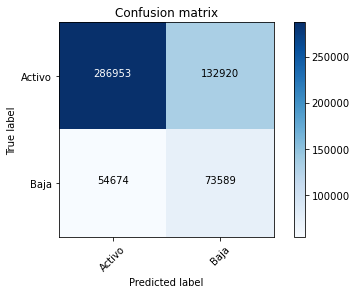

In [30]:
print(classification_report(y_test,y_pred ))

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

### Regresión Logística

Logistic Accuracy is 0.75
Cross Validation Score = 0.75
              precision    recall  f1-score   support

           0       0.89      0.77      0.82     83975
           1       0.47      0.68      0.56     25653

    accuracy                           0.75    109628
   macro avg       0.68      0.72      0.69    109628
weighted avg       0.79      0.75      0.76    109628



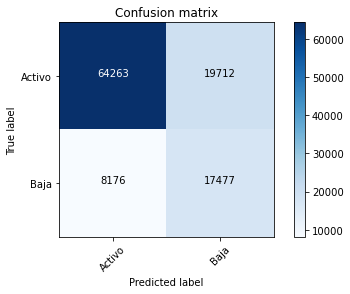

In [14]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state = 0, max_iter=1000, class_weight="balanced")
LR.fit(X_train,y_train) 
print ("Logistic Accuracy is %2.2f" % accuracy_score(y_test, LR.predict(X_test)))

skf = StratifiedKFold(n_splits=5)
score_LR = cross_val_score(LR, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_LR)

y_pred = LR.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.79


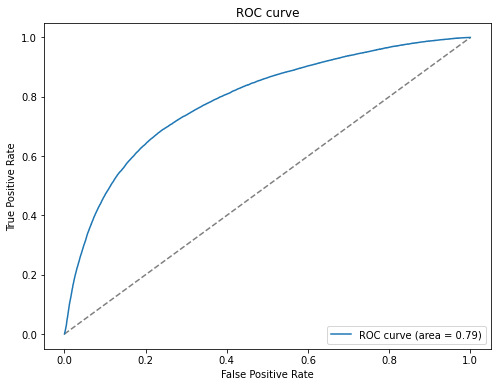

In [47]:
plot_roc_curve(LR, X_test, y_test)

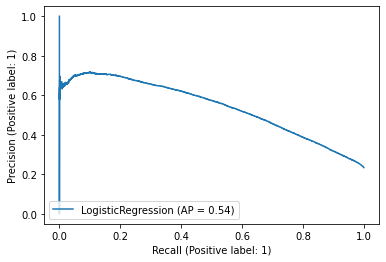

In [48]:
plot_precision_recall_curve(LR, X_test, y_test);

In [49]:
filename = '../pkl/LR_model.pkl'
LR_model = LR.fit(X_train, y_train)

pickle.dump(LR_model, open(filename,'wb'))

### Decission Tree Classifier

Decision Tree Accuracy is 0.75
Cross Validation Score = 0.75
              precision    recall  f1-score   support

           0       0.89      0.76      0.82     83975
           1       0.47      0.71      0.57     25653

    accuracy                           0.75    109628
   macro avg       0.68      0.73      0.69    109628
weighted avg       0.80      0.75      0.76    109628



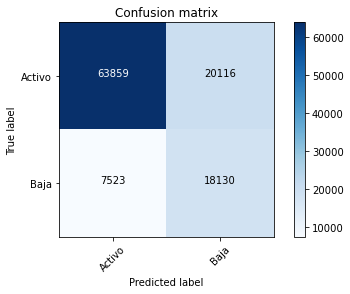

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

DT = DecisionTreeClassifier(random_state = 0,class_weight="balanced", min_weight_fraction_leaf=0.01)
DT = DT.fit(X_train,y_train)
print ("Decision Tree Accuracy is %2.2f" % accuracy_score(y_test, DT.predict(X_test)))

skf = StratifiedKFold(n_splits=5)
score_DT = cross_val_score(DT, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_DT)

y_pred = DT.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.81


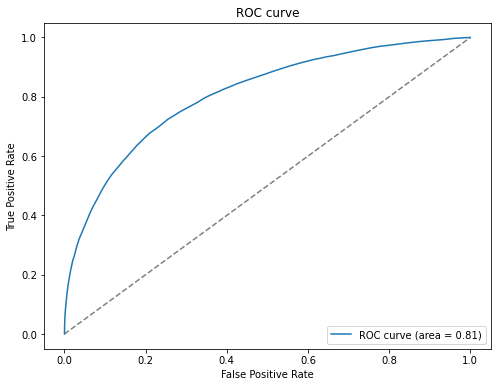

In [51]:
plot_roc_curve(DT, X_test, y_test)

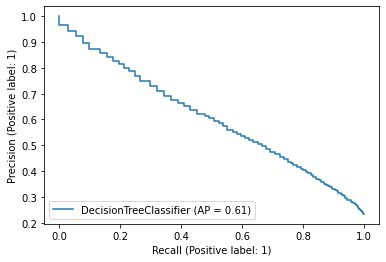

In [52]:
plot_precision_recall_curve(DT, X_test, y_test);

In [53]:
filename = '../pkl/DT_model.pkl'
DT_model = DT.fit(X_train, y_train)

pickle.dump(DT_model, open(filename,'wb'))

### Random Forest Classifier

Random Forest Accuracy is 0.83
Cross Validation Score = 0.83
              precision    recall  f1-score   support

           0       0.88      0.89      0.89     83975
           1       0.63      0.61      0.62     25653

    accuracy                           0.83    109628
   macro avg       0.76      0.75      0.75    109628
weighted avg       0.82      0.83      0.82    109628



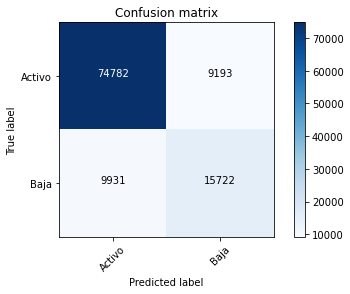

In [15]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=10,class_weight="balanced")
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("Random Forest Accuracy is %2.2f" % accuracy_score(y_test, y_pred))

skf = StratifiedKFold(n_splits=20)
score_rfc = cross_val_score(rfc, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_rfc)

print(classification_report(y_test,y_pred ))

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.85


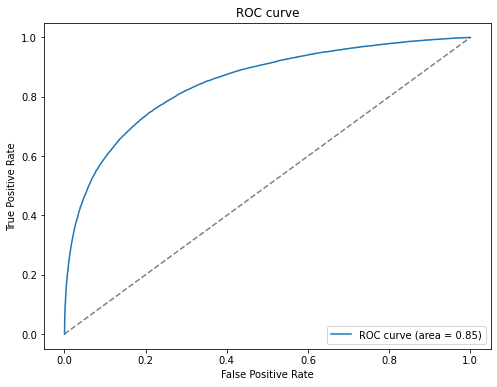

In [56]:
plot_roc_curve(rfc, X_test, y_test)

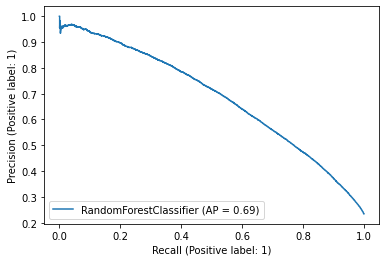

In [57]:
plot_precision_recall_curve(rfc, X_test, y_test);

#### Random Forest parameter tuning

{'bootstrap': False,  
 'max_depth': None,  
 'max_features': 'auto',  
 'min_samples_leaf': 3,  
 'min_samples_split': 5,  
 'n_estimators': 300}

Random Forest Accuracy is 0.82
Cross Validation Score = 0.82
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     83975
           1       0.60      0.65      0.62     25653

    accuracy                           0.82    109628
   macro avg       0.75      0.76      0.75    109628
weighted avg       0.82      0.82      0.82    109628



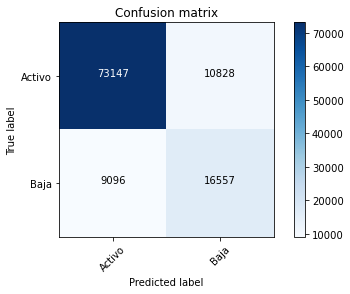

In [16]:
# Don´t do this!!!

from sklearn.ensemble import RandomForestClassifier

rfc_2 = RandomForestClassifier(min_samples_leaf = 3, 
                                       min_samples_split = 5,
                                       max_depth = None,
                                       n_estimators = 300, 
                                       max_features = 'auto', 
                                       bootstrap = False, class_weight = "balanced")
rfc_2.fit(X_train, y_train)
y_pred = rfc_2.predict(X_test)

print("Random Forest Accuracy is %2.2f" % accuracy_score(y_test, y_pred))

skf = StratifiedKFold(n_splits=10)
score_rfc2 = cross_val_score(rfc_2, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_rfc2)


print(classification_report(y_test,y_pred ))

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

In [17]:
filename = '../pkl/rfc_model.pkl'
rfc_model = rfc.fit(X_train, y_train)

pickle.dump(rfc_model, open(filename,'wb'))

ROC AUC score: 0.85


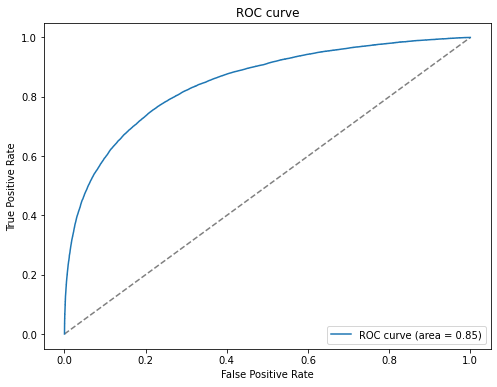

In [18]:
plot_roc_curve(rfc_2, X_test, y_test);

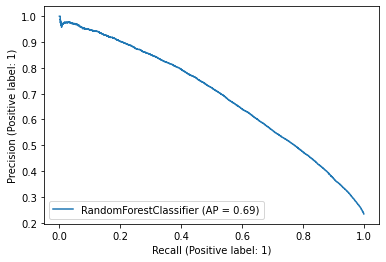

In [19]:
plot_precision_recall_curve(rfc_2, X_test, y_test);

### XGBoost

GradientBoost Accuracy= 0.84
Cross Validation Score = 0.84
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     83975
           1       0.76      0.47      0.58     25653

    accuracy                           0.84    109628
   macro avg       0.81      0.71      0.74    109628
weighted avg       0.83      0.84      0.83    109628



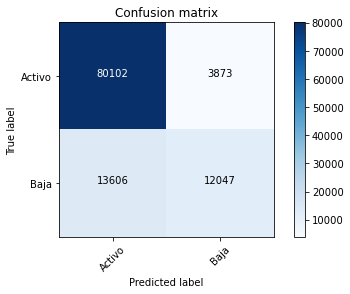

In [20]:
# Don´t do this!!!

from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=1000, booster='gbtree', learning_rate=0.01, objective='binary:logistic')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print ("GradientBoost Accuracy= %2.2f" % accuracy_score(y_test, y_pred))

skf = StratifiedKFold(n_splits=5)
score_xgb = cross_val_score(xgb, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_xgb)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.85


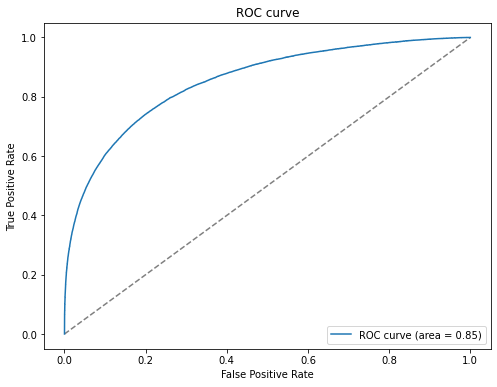

In [59]:
plot_roc_curve(xgb, X_test, y_test)

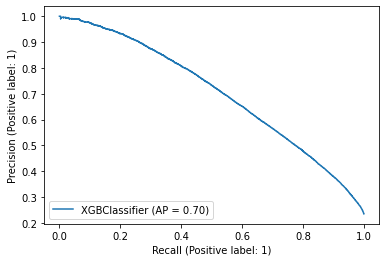

In [60]:
plot_precision_recall_curve(xgb, X_test, y_test);

In [61]:
filename = '../pkl/xgb_model.pkl'
xgb_model = xgb.fit(X_train, y_train)

pickle.dump(xgb_model, open(filename,'wb'))

### Voting Classifier

Utilizando Regresión Logística y Decission Tree Classifier.

VotingClassifier Accuracy= 0.76
Cross Validation Score = 0.76
              precision    recall  f1-score   support

           0       0.90      0.77      0.83     83975
           1       0.49      0.71      0.58     25653

    accuracy                           0.76    109628
   macro avg       0.69      0.74      0.70    109628
weighted avg       0.80      0.76      0.77    109628



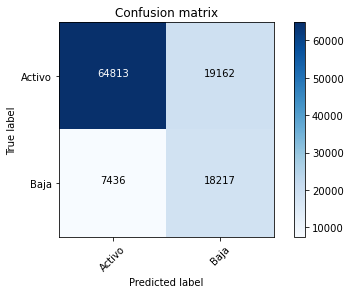

In [17]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
         ('lr', LR), ('dt', DT)],
         voting='soft')

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
print ("VotingClassifier Accuracy= %2.2f" % accuracy_score(y_test, y_pred))

skf = StratifiedKFold(n_splits=5)
score_voting_clf = cross_val_score(voting_clf, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_voting_clf)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

In [18]:
filename = '../pkl/voting_clf_model.pkl'
voting_clf_model = voting_clf.fit(X_train, y_train)

pickle.dump(voting_clf_model, open(filename,'wb'))

ROC AUC score: 0.82


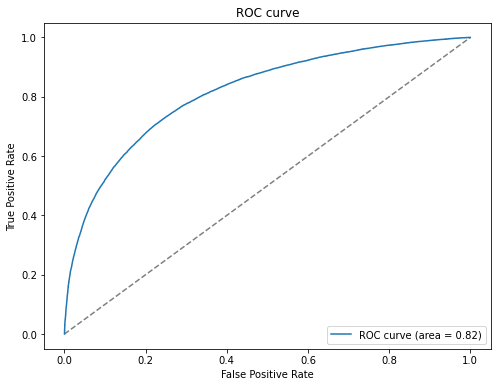

In [19]:
plot_roc_curve(voting_clf, X_test, y_test);

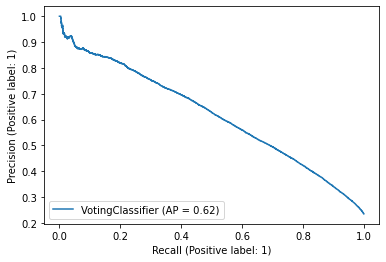

In [20]:
plot_precision_recall_curve(voting_clf, X_test, y_test);

### Comparing ROC Curves

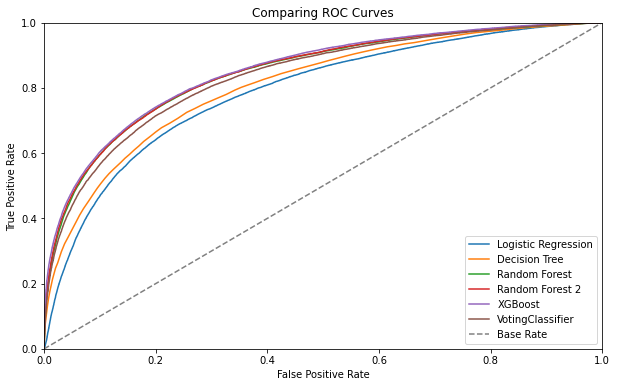

In [25]:
plt.figure(figsize = (10,6), linewidth= 1)

LR_fpr, LR_tpr, thresholds = roc_curve(y_test, LR.predict_proba(X_test)[:,1])
DT_fpr, DT_tpr, thresholds = roc_curve(y_test, DT.predict_proba(X_test)[:,1])
rfc_fpr, rfc_tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
rfc2_fpr, rfc2_tpr, thresholds = roc_curve(y_test, rfc_2.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
vc_fpr, vc_tpr, thresholds = roc_curve(y_test, voting_clf.predict_proba(X_test)[:,1])

plt.plot(LR_fpr, LR_tpr, label='Logistic Regression')
plt.plot(DT_fpr, DT_tpr, label='Decision Tree')
plt.plot(rfc_fpr, rfc_tpr, label='Random Forest')
plt.plot(rfc2_fpr, rfc2_tpr, label='Random Forest 2')
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost')
plt.plot(vc_fpr, vc_tpr, label='VotingClassifier')

plt.plot([0,1],[0,1],label='Base Rate', ls = '--', c = 'grey')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Comparing ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Comparing PR Curves

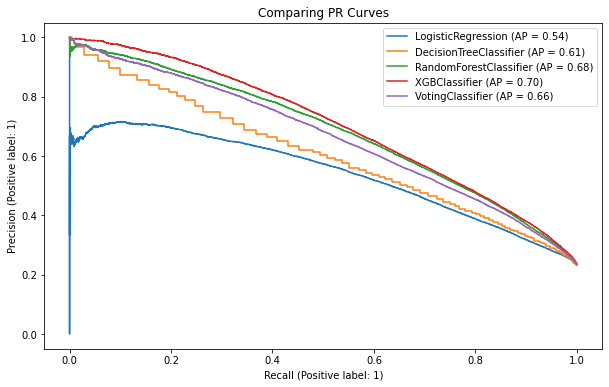

In [26]:
models = [LR, DT, rfc, xgb, voting_clf]

fig, ax = plt.subplots(figsize=(10, 6))
for m in models:
    plot_precision_recall_curve(m, X_test, y_test, ax=ax)
    plt.legend(loc="upper right")
ax.set_title("Comparing PR Curves");

### Feature importances

In [64]:
from sklearn.feature_selection import RFE

# Using Recursive Feature Elimination Function and fitting it in a Logistic Regression Model
modell = LogisticRegression(max_iter=1000, class_weight="balanced")
rfe = RFE(modell, 5)
rfe = rfe.fit(X_train,y_train)

rfe.ranking_

C:\Users\alber\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([ 9,  5,  2,  6,  7,  3,  4,  1,  1,  1, 10,  8,  1,  1])

In [65]:
result = zip(X_train.columns, rfe.ranking_)

result_set = set(result)
print(result_set)

{('Provincia', 3), ('Incidencias_sca', 1), ('Housing Type', 5), ('Nationality', 4), ('Gender', 9), ('Income', 1), ('Rango_Edad', 1), ('Number Pay', 10), ('Marital Status', 7), ('Dias_Activo_sca', 8), ('Labor Situation', 6), ('Property Type', 2), ('Rango Precio', 1), ('Quejas_sca', 1)}


[0.01966882 0.0371612  0.07905773 0.04246538 0.02724723 0.13567729
 0.02381456 0.0552098  0.05390181 0.06442401 0.03145203 0.23554662
 0.08876075 0.10561276]


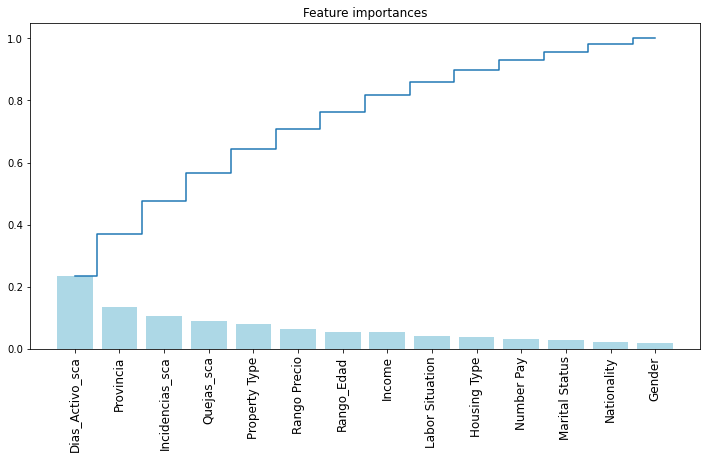

In [66]:
from sklearn.ensemble import ExtraTreesClassifier

# Using ExtraTreesClassifier model function
model = ExtraTreesClassifier()
model.fit(X_train, y_train)

# Printing important features in the model
print(model.feature_importances_)
importances = model.feature_importances_
feat_names = data_filtered.drop(['Status'],axis=1).columns

# Displaying the feature importances as a chart by sorting it in the order of importances
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=12)
plt.xlim([-1, len(indices)])
plt.show()